# TMLE Example Notebook

This notebook demonstrates the issue of using uplift curves without knowing true treatment effect and how to solve it by using TMLE as a proxy of the true treatment effect.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
base_path = os.path.abspath("../")
os.chdir(base_path)

In [3]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import sys
import warnings
warnings.simplefilter("ignore", UserWarning)

from lightgbm import LGBMRegressor

In [4]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import *
from causalml.propensity import calibrate

import importlib
print(importlib.metadata.version('causalml') )

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Failed to import duecredit due to No module named 'duecredit'


0.14.0


In [5]:
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

## Generating Synthetic Data

In [6]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=1000000, p=10, sigma=5.)

In [7]:
X_train, X_test, y_train, y_test, e_train, e_test, treatment_train, treatment_test, tau_train, tau_test, b_train, b_test = train_test_split(X, y, e, treatment, tau, b, test_size=0.5, random_state=42)

## Calculating Individual Treatment Effect (ITE/CATE)

In [8]:
# X Learner
learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_test = learner_x.predict(X=X_test, p=e_test, treatment=treatment_test).flatten()

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 241257, number of used features: 10
[LightGBM] [Info] Start training from score 1.024617
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 258743, number of used features: 10
[LightGBM] [Info] Start training from score 1.938288
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

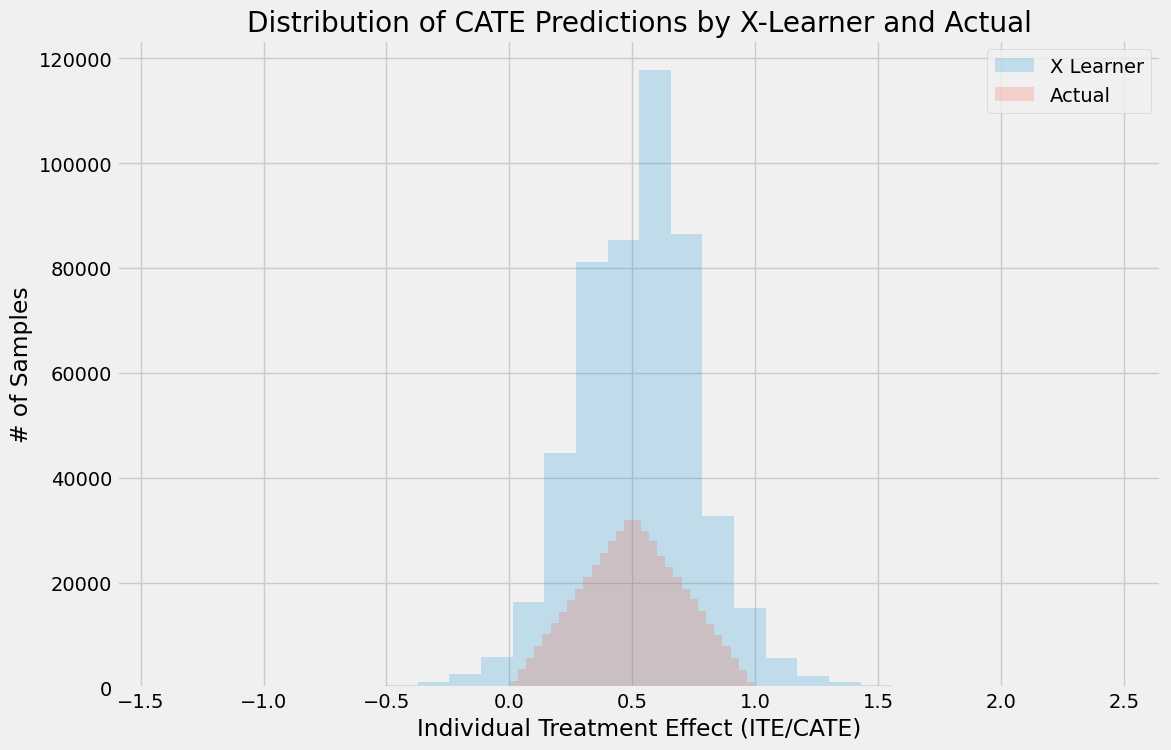

In [9]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_x_test, alpha=alpha, bins=bins, label='X Learner')
plt.hist(tau_test, alpha=alpha, bins=bins, label='Actual')

plt.title('Distribution of CATE Predictions by X-Learner and Actual')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## Validating CATE without TMLE

In [10]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'tau': tau_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

### Uplift Curve With Ground Truth

If true treatment effect is known as in simulations, the uplift curve of a model uses the cumulative sum of the treatment effect sorted by model's CATE estimate.

In the figure below, the uplift curve of X-learner shows positive lift close to the optimal lift by the ground truth.

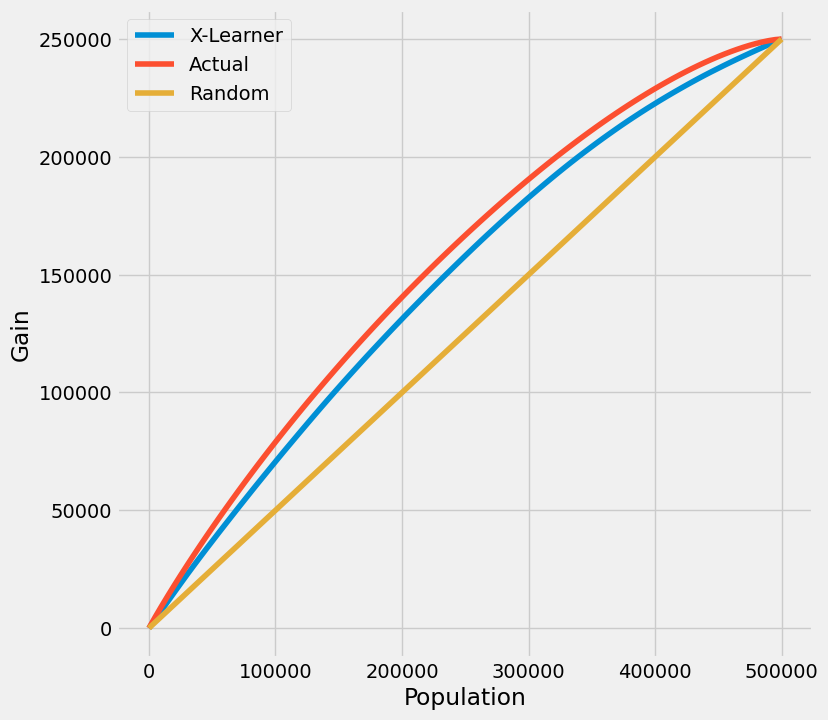

In [11]:
plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')

### Uplift Curve Without Ground Truth

If true treatment effect is unknown as in practice, the uplift curve of a model uses the cumulative mean difference of outcome in the treatment and control group sorted by model's CATE estimate.

In the figure below, the uplift curves of X-learner as well as the ground truth show no lift incorrectly.

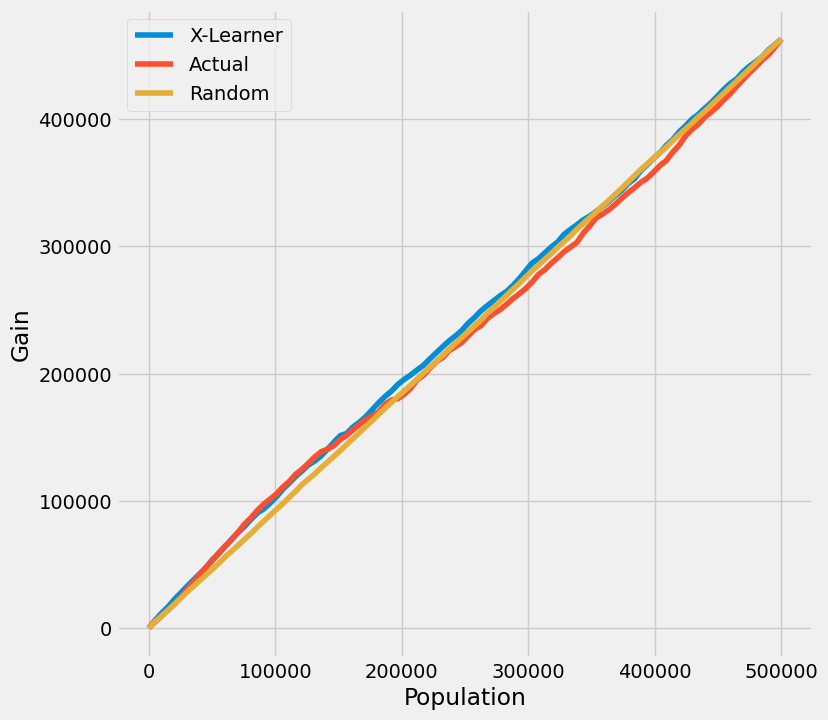

In [12]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

## TMLE 

### Uplift Curve with TMLE as Ground Truth

In [13]:
n_fold = 5
kf = KFold(n_splits=n_fold)

In [14]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'p': e_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

In [15]:
inference_cols = []
for i in range(X_test.shape[1]):
    col = 'col_' + str(i)
    df[col] = X_test[:,i]
    inference_cols.append(col)

In [16]:
df.head()

,y,w,p,X-Learner,Actual,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,5.592515,0,0.202896,0.334329,0.292975,0.148756,0.437193,0.028430,0.185762,0.950320,0.322688,0.633199,0.161233,0.568961,0.326207
1,-5.246647,1,0.900000,0.666233,0.642620,0.675881,0.609360,0.408932,0.345265,0.778955,0.184961,0.714186,0.203995,0.153572,0.158185
2,2.661938,0,0.100000,0.782345,0.179740,0.301853,0.057627,0.975064,0.375028,0.729631,0.011072,0.646172,0.939145,0.570872,0.538346
3,1.804286,1,0.900000,0.844541,0.761978,0.812735,0.711222,0.590143,0.198804,0.125635,0.953690,0.553724,0.889793,0.617592,0.123138
4,3.586306,1,0.338176,0.468232,0.385212,0.581626,0.188798,0.232100,0.277555,0.193887,0.894191,0.553785,0.977229,0.234704,0.899787


In [17]:
tmle_df = get_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

In [18]:
tmle_df

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
0.2,0.154414,0.168955,0.105331
0.4,0.284206,0.312309,0.210663
0.6,0.400735,0.413102,0.315994
0.8,0.478416,0.490350,0.421326
1.0,0.526657,0.526657,0.526657


#### Uplift Curve wihtout CI

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

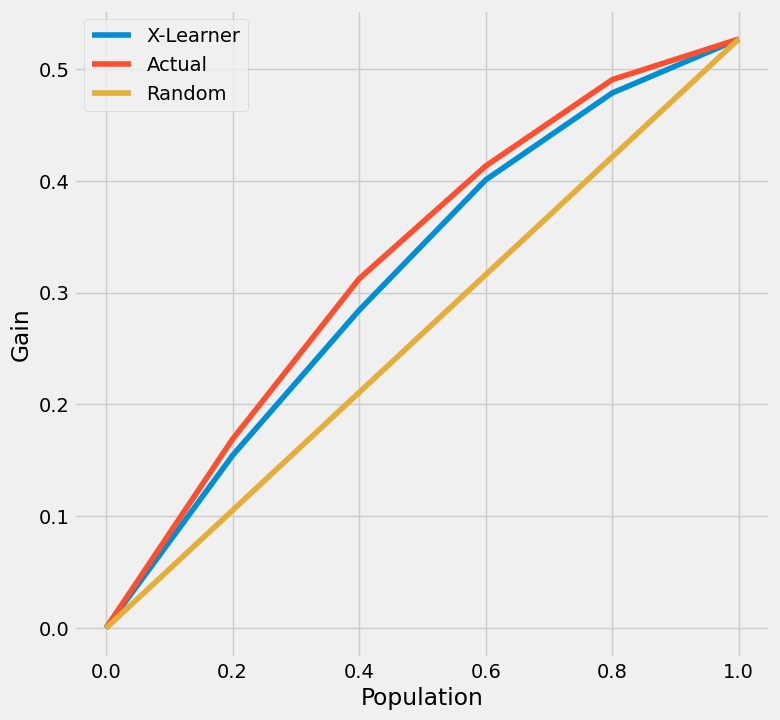

In [19]:
plot_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

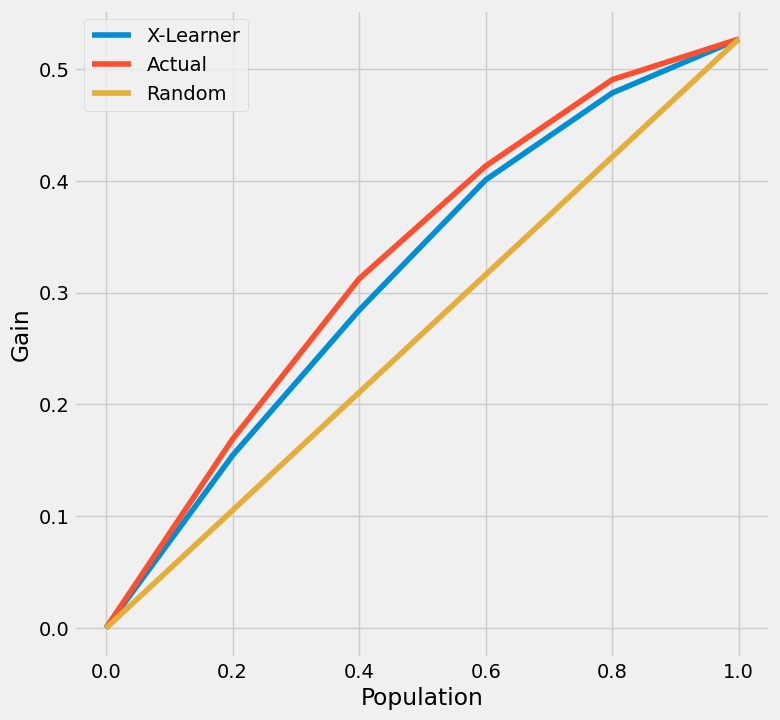

In [20]:
plot(df, kind='gain', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### AUUC Score

In [21]:
auuc_score(df, tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
           n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

X-Learner    0.307405
Actual       0.318562
Random       0.263329
dtype: float64

#### Uplift Curve with CI

In [22]:
tmle_df = get_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

In [23]:
tmle_df

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.2,0.154414,0.168955,0.136646,0.149932,0.172182,0.187978,0.105331
0.4,0.284206,0.312309,0.248567,0.275047,0.319845,0.349571,0.210663
0.6,0.400735,0.413102,0.348763,0.361819,0.452707,0.464385,0.315994
0.8,0.478416,0.490350,0.410527,0.423889,0.546305,0.556811,0.421326
1.0,0.526657,0.526657,0.488261,0.488261,0.565054,0.565054,0.526657


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

No handles with labels found to put in legend.


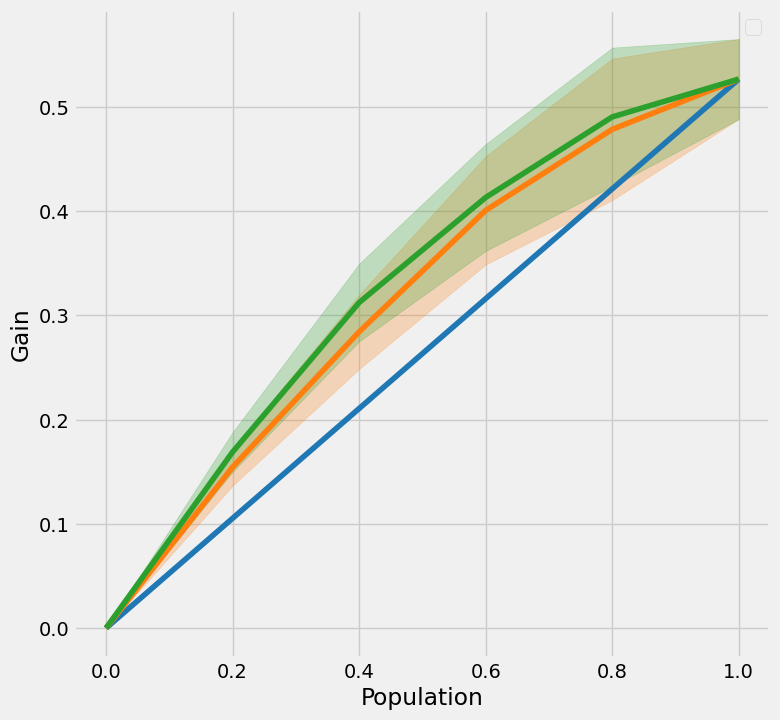

In [24]:
plot_tmlegain(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

No handles with labels found to put in legend.


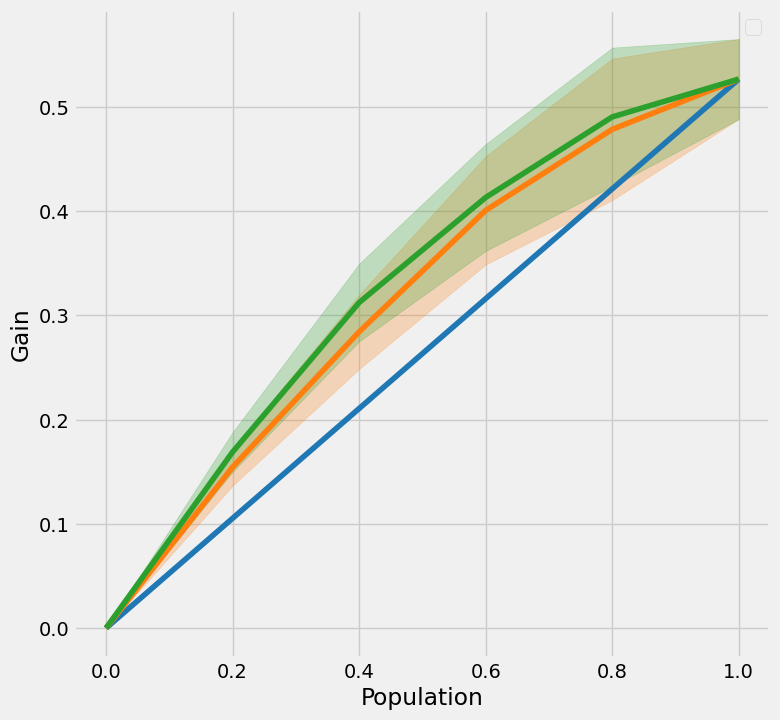

In [25]:
plot(df, kind='gain', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

### Qini Curve with TMLE as Ground Truth

#### Qini Curve without CI

In [26]:
qini = get_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

In [27]:
qini

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
100000.0,55701.612807,68814.594207,27330.146905
200000.0,101765.600709,127538.065453,54660.293811
300000.0,135226.960828,153415.183954,81990.440716
400000.0,149808.426401,165477.436011,109320.587621
500000.0,136650.734527,136650.734527,136650.734527


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

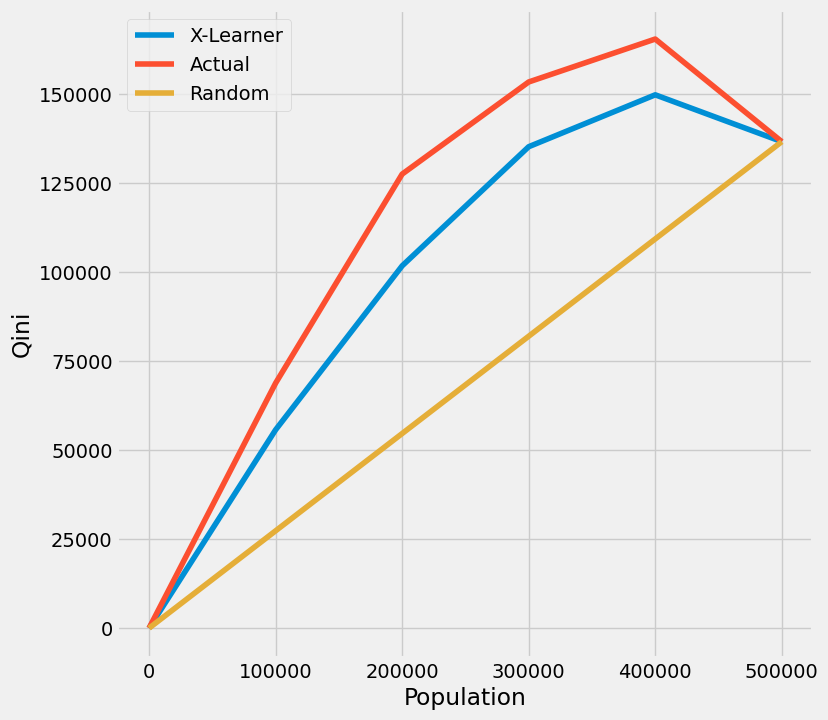

In [28]:
plot_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

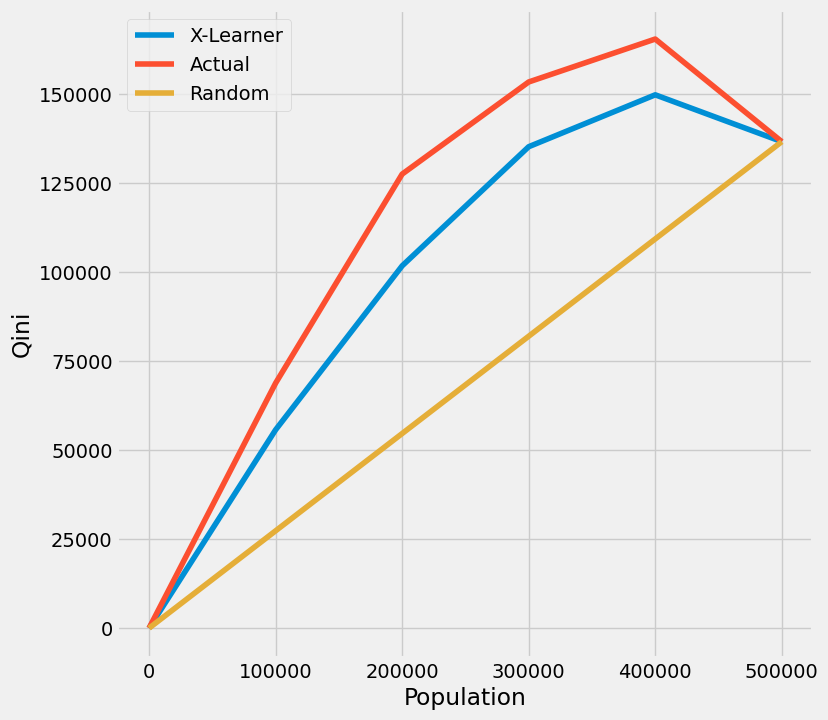

In [29]:
plot(df, kind='qini', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### Qini Score

In [30]:
qini_score(df, tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
           n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

X-Learner    28200.188615
Actual       40323.968429
Random           0.000000
dtype: float64

#### Qini Curve with CI

In [31]:
qini = get_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

In [32]:
qini

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100000.0,55701.612807,68814.594207,49292.135917,61066.690301,62111.089696,76562.498112,27330.146905
200000.0,101765.600709,127538.065453,89013.774860,112318.690918,114517.426558,142757.439989,54660.293811
300000.0,135226.960828,153415.183954,117785.051912,134596.152416,152668.869744,172234.215491,81990.440716
400000.0,149808.426401,165477.436011,129378.673003,144288.393417,170238.179799,186666.478606,109320.587621
500000.0,136650.734527,136650.734527,136650.734527,136650.734527,136650.734527,136650.734527,136650.734527


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

No handles with labels found to put in legend.


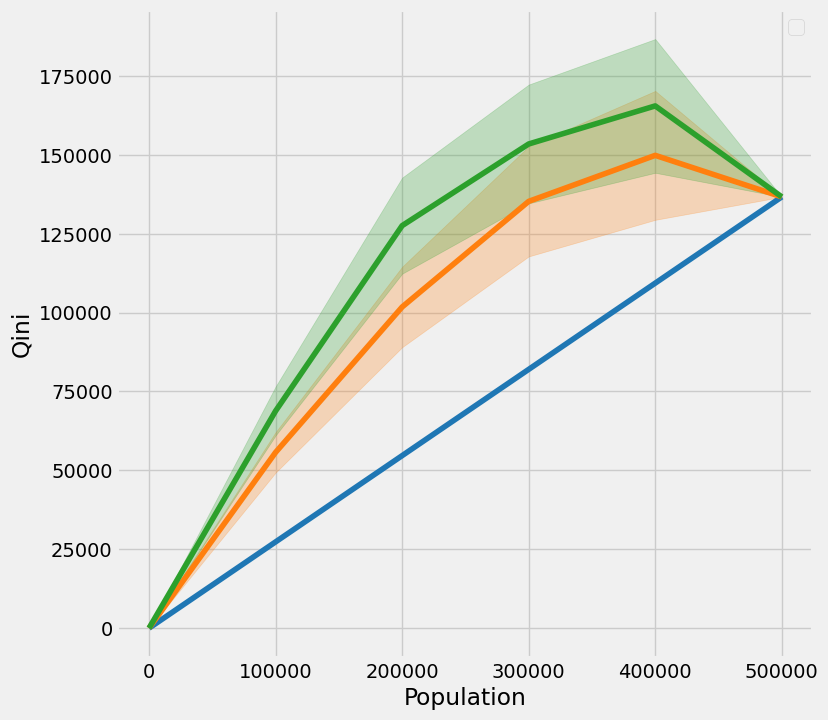

In [33]:
plot_tmleqini(df, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.503896
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 400000, number of used features: 11
[LightGBM] [Info] Start training from score 1.495384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

No handles with labels found to put in legend.


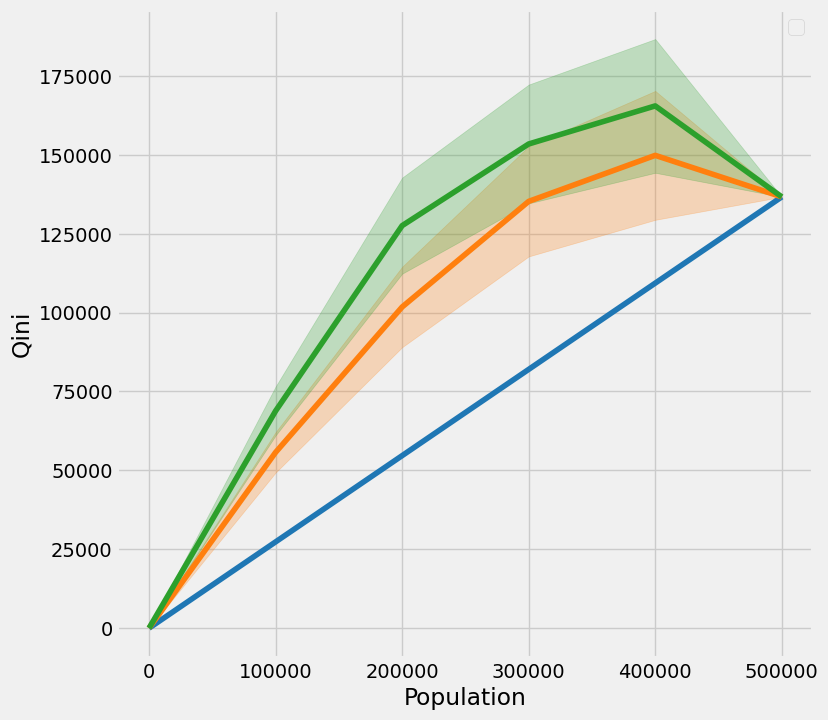

In [34]:
plot(df, kind='qini', tmle=True, inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)